In [140]:
import os
import torch
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import matplotlib.pyplot as plt
from torchvision.models.detection import FasterRCNN_ResNet50_FPN_Weights
import cv2
from PIL import Image
import random
import json

# Load Data and Preprocess

In [141]:
label_map = {'mine':0,'store':1,'attack':2,'nospace':3,'nomine':4}
label_count = {0:0,1:0,2:0,3:0,4:0}

In [142]:
class EVEDataset(Dataset):
    def __init__(self, root):
        # roots
        self.root = root
        self.images_root = os.path.join(root, 'images')
        self.anns_root = os.path.join(root,'annotations')
        
        # data
        self.image_paths = []
        self.targets = []
        
        self.initialize()
    def initialize(self):
        annotations = os.listdir(self.anns_root)
        for ann in annotations:
            ann_path = os.path.join(self.anns_root,ann)
            with open(ann_path, 'r') as file:
                data = dict(json.load(file))
                image_path = os.path.join(self.images_root,data['imagePath'])
                boxes = []
                labels = []
                objects = data['shapes']
                random.shuffle(objects)
                for obj in objects:
                    label = label_map[obj['label']]
                    label_count[label]+=1
                    box = obj['points']
                    box = [box[0][0],box[0][1],box[1][0],box[1][1]]
                    boxes.append(box)
                    labels.append(label)
                self.targets.append({"boxes": torch.tensor(boxes), "labels": torch.tensor(labels)}) 
                self.image_paths.append(image_path)
              
    def __len__(self):
        return len(self.targets)
    
    def __getitem__(self, idx):
        image = ToTensor()(Image.open(self.image_paths[idx]).convert("RGB"))
        target = self.targets[idx]
        return image, target

In [143]:
data_train = EVEDataset("data")

In [144]:
label_count

{0: 22, 1: 10, 2: 10, 3: 11, 4: 9}

# Create Dataloader

In [145]:
def collate(x):
    return tuple(zip(*x))
batch_size = 2
train_loader = DataLoader(data_train, batch_size=batch_size, shuffle=True,collate_fn=collate)

# Model Construction

In [146]:
# load pretrained Faster R-CNN model
model = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT)

# change box_predictor
num_classes = len(label_map) + 1 # number of classes plus background
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

# setup device
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
model.to(device)

# setup optimizer and scheduler
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.Adam(params, lr=1e-4)
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Train

In [147]:
num_epochs = 40

for epoch in range(num_epochs):
    model.train()
    
    # train
    epoch_loss = 0
    for images, targets in train_loader:
        # load data to device
        images = [img.to(device) for img in images]
        targets = [{k: v.to(device) for k,v in t.items()}  for t in targets]
        
        loss_dict = model(images, targets)
        loss = sum(loss_dict.values())
        
        # update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()*2
        

    print(f"Epoch: {epoch}, Loss: {epoch_loss/18}")
        
    # lr_scheduler.step() 

print("Training completed.")

Epoch: 0, Loss: 1.4213128520382776
Epoch: 1, Loss: 0.5044430651598506
Epoch: 2, Loss: 0.40076083441575366
Epoch: 3, Loss: 0.3364246057139503
Epoch: 4, Loss: 0.2906831188334359
Epoch: 5, Loss: 0.22100134856171078
Epoch: 6, Loss: 0.2063957800467809
Epoch: 7, Loss: 0.22773952533801398
Epoch: 8, Loss: 0.19808613964253002
Epoch: 9, Loss: 0.2585408008760876
Epoch: 10, Loss: 0.23081089473432964
Epoch: 11, Loss: 0.20964437847336134
Epoch: 12, Loss: 0.17280280631449488
Epoch: 13, Loss: 0.16561631506515873
Epoch: 14, Loss: 0.13594872090551588
Epoch: 15, Loss: 0.113575113316377
Epoch: 16, Loss: 0.11018157584799661
Epoch: 17, Loss: 0.11166490986943245
Epoch: 18, Loss: 0.08871257346537378
Epoch: 19, Loss: 0.10458983356753986
Epoch: 20, Loss: 0.13482265215781
Epoch: 21, Loss: 0.10263600221110715
Epoch: 22, Loss: 0.07875363280375798
Epoch: 23, Loss: 0.10052639310662118
Epoch: 24, Loss: 0.12340150525172551
Epoch: 25, Loss: 0.1398285407986906
Epoch: 26, Loss: 0.13746120035648346
Epoch: 27, Loss: 0.1039

# Evaluation

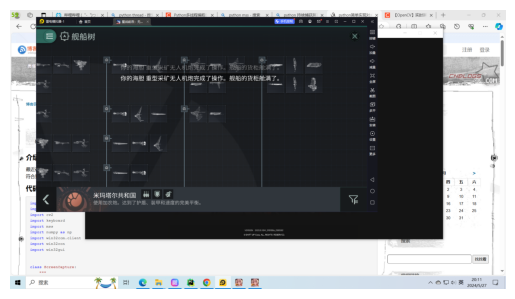

In [148]:
img_id = 1
img=cv2.imread(data_train.image_paths[img_id],cv2.IMREAD_UNCHANGED)
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))  
plt.axis('off')
plt.show()

In [149]:
image, target = data_train[img_id]
image=image.to(device)
target = {k: v.to(device) for k,v in target.items()}
model.eval()
with torch.no_grad():
    output = model([image])

In [150]:
output[0]

{'boxes': tensor([[ 418.6851,  212.2772, 1046.1609,  239.2334],
         [ 436.7290,  250.3127, 1034.9696,  279.1318],
         [ 485.3615,  188.7579,  979.5306,  214.2300]], device='cuda:0'),
 'labels': tensor([3, 3, 3], device='cuda:0'),
 'scores': tensor([0.9950, 0.9917, 0.0605], device='cuda:0')}

In [151]:
detections = output[0]
for i in range(len(detections["boxes"])):
    label=detections['labels'][i]
    box=detections['boxes'][i]
    score=detections['scores'][i]
    if score>0.9:
        if box[2]>box[0] and box[3]>box[1]:
            cv2.rectangle(img, (int(box[0]), int(box[1])), (int(box[2]), int(box[3])), (255, 0, 0), 2)

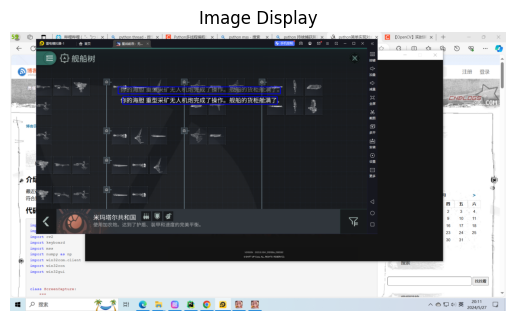

In [152]:
plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.title('Image Display')
plt.axis('off') 
plt.show()

In [155]:
torch.save(model, "data/eve_mine.pth")